<a href="https://colab.research.google.com/github/adnanfathoni88/BigData-ecom_price_prediction/blob/main/UAS_BIG_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ecommerce_dataset_updated.csv").getOrCreate()

In [ ]:
spark_df = spark.read.csv("ecommerce_dataset_updated.csv", header=True, inferSchema=True)
spark_df.show(5)

+--------+----------+--------+-----------+------------+----------------+--------------+-------------+
| User_ID|Product_ID|Category|Price (Rs.)|Discount (%)|Final_Price(Rs.)|Payment_Method|Purchase_Date|
+--------+----------+--------+-----------+------------+----------------+--------------+-------------+
|337c166f|f414122f-e|  Sports|      36.53|          15|           31.05|   Net Banking|   12-11-2024|
|d38a19bf|fde50f9c-5|Clothing|     232.79|          20|          186.23|   Net Banking|   09-02-2024|
|d7f5f0b0|0d96fc90-3|  Sports|     317.02|          25|          237.76|   Credit Card|   01-09-2024|
|395d4994|964fc44b-d|    Toys|     173.19|          25|          129.89|           UPI|   01-04-2024|
|a83c145c|d70e2fc6-e|  Beauty|      244.8|          20|          195.84|   Net Banking|   27-09-2024|
+--------+----------+--------+-----------+------------+----------------+--------------+-------------+
only showing top 5 rows



# 1c. Pre-processing Data

Rename kolom (User_ID menjadi userId)

In [64]:
from pyspark.sql.functions import col

# Daftar kolom lama dan baru
old_columns = ['User_ID', 'Product_ID', 'Category', 'Price (Rs.)', 'Discount (%)', 'Final_Price(Rs.)', 'Payment_Method', 'Purchase_Date']
new_columns = ['userId', 'productId', 'category', 'priceRs', 'discountPercent', 'finalPriceRs', 'paymentMethod', 'purchaseDate']

# Loop untuk mengganti nama kolom
for old_col, new_col in zip(old_columns, new_columns):
    spark_df = spark_df.withColumnRenamed(old_col, new_col)

# Menampilkan DataFrame dengan nama kolom yang sudah diubah
spark_df.printSchema()
spark_df.show(5)

root
 |-- userId: string (nullable = true)
 |-- productId: string (nullable = true)
 |-- category: string (nullable = true)
 |-- priceRs: double (nullable = true)
 |-- discountPercent: integer (nullable = true)
 |-- finalPriceRs: double (nullable = true)
 |-- paymentMethod: string (nullable = true)
 |-- purchaseDate: string (nullable = true)

+--------+----------+--------+-------+---------------+------------+-------------+------------+
|  userId| productId|category|priceRs|discountPercent|finalPriceRs|paymentMethod|purchaseDate|
+--------+----------+--------+-------+---------------+------------+-------------+------------+
|337c166f|f414122f-e|  Sports|  36.53|             15|       31.05|  Net Banking|  12-11-2024|
|d38a19bf|fde50f9c-5|Clothing| 232.79|             20|      186.23|  Net Banking|  09-02-2024|
|d7f5f0b0|0d96fc90-3|  Sports| 317.02|             25|      237.76|  Credit Card|  01-09-2024|
|395d4994|964fc44b-d|    Toys| 173.19|             25|      129.89|          UPI|  01

Mendapatkan jumlah nilai null setiap kolom

In [65]:
from pyspark.sql.functions import when, count, col

# Mendapatkan jumlah nilai null di setiap kolom
for col_name in spark_df.columns:
    if col_name in spark_df.columns:
        null_count = spark_df.filter(col(col_name).isNull()).count()
        print(f"Jumlah nilai null di kolom {col_name}: {null_count}")
    else:
        print(f"Column '{col_name}' not found in DataFrame.")

Jumlah nilai null di kolom userId: 0
Jumlah nilai null di kolom productId: 0
Jumlah nilai null di kolom category: 0
Jumlah nilai null di kolom priceRs: 0
Jumlah nilai null di kolom discountPercent: 0
Jumlah nilai null di kolom finalPriceRs: 0
Jumlah nilai null di kolom paymentMethod: 0
Jumlah nilai null di kolom purchaseDate: 0


Summary Dataset

In [ ]:
spark_df.describe().show()

+-------+--------+------------------+--------+------------------+------------------+------------------+----------------+------------+
|summary|  userId|         productId|category|           priceRs|   discountPercent|      finalPriceRs|   paymentMethod|purchaseDate|
+-------+--------+------------------+--------+------------------+------------------+------------------+----------------+------------+
|  count|    3660|              3660|    3660|              3660|              3660|              3660|            3660|        3660|
|   mean|Infinity|31894.335677167626|    NULL|254.80067486338828|18.825136612021858| 206.9065792349723|            NULL|        NULL|
| stddev|     NaN| 78431.18226242489|    NULL|141.68262131940904|14.731338104095204|122.68784393226919|            NULL|        NULL|
|    min|001ae40d|        003d1f09-c|  Beauty|             10.09|                 0|              5.89|Cash on Delivery|  01-01-2024|
|    max|fffca9db|        ffc76feb-5|    Toys|            499.

Korelasi data

In [66]:
from pyspark.sql.functions import corr

# Daftar kolom numerik
numeric_columns = ['priceRs', 'discountPercent', 'finalPriceRs']

# Menghitung korelasi antar kolom numerik
for col1 in numeric_columns:
    for col2 in numeric_columns:
        if col1 != col2:
            correlation = spark_df.select(corr(col1, col2).alias("correlation")).collect()[0]["correlation"]
            print(f"Korelasi antara {col1} dan {col2}: {correlation}")

Korelasi antara priceRs dan discountPercent: -0.0034733790555469173
Korelasi antara priceRs dan finalPriceRs: 0.9356911119813707
Korelasi antara discountPercent dan priceRs: -0.0034733790555469325
Korelasi antara discountPercent dan finalPriceRs: -0.31151491324319386
Korelasi antara finalPriceRs dan priceRs: 0.9356911119813703
Korelasi antara finalPriceRs dan discountPercent: -0.3115149132431938


#1d. exploratory data analysis (EDA)

In [ ]:
pandas_df = spark_df.toPandas()

Jumlah produk berdasarkan kategori (BAR CHART) <br>
data = category, priceRs, discountPercent, finalPriceRs

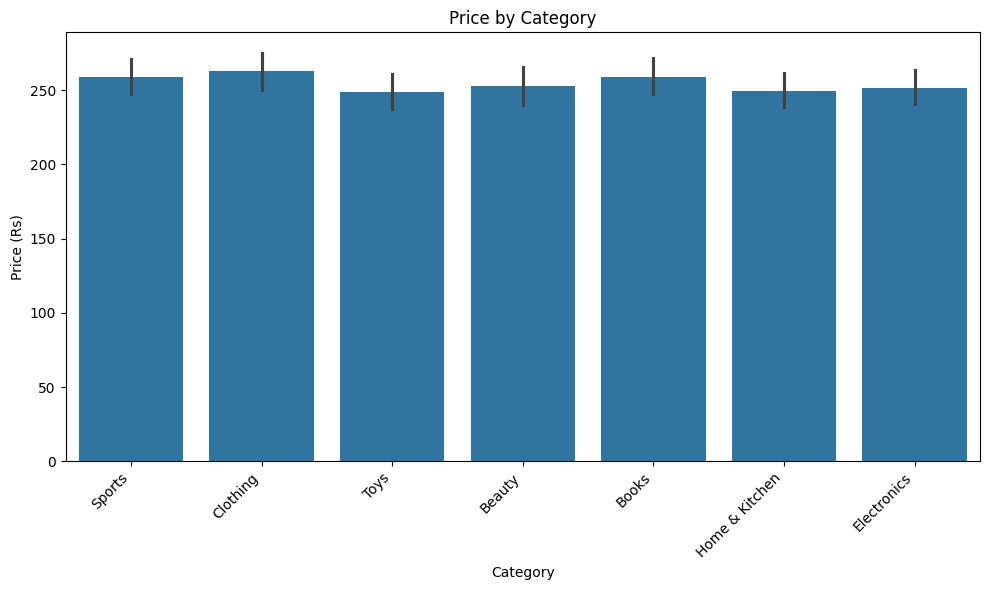

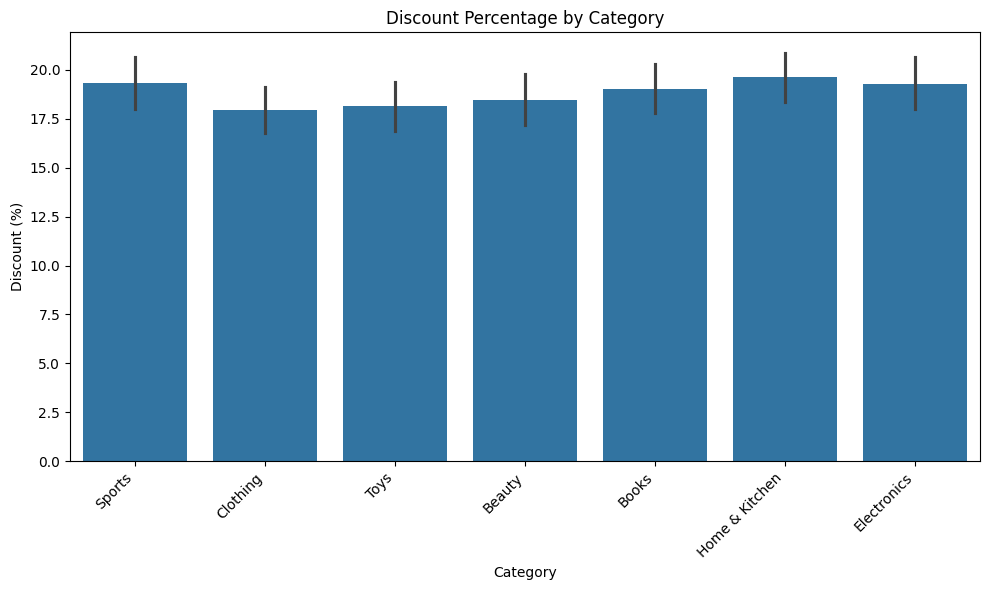

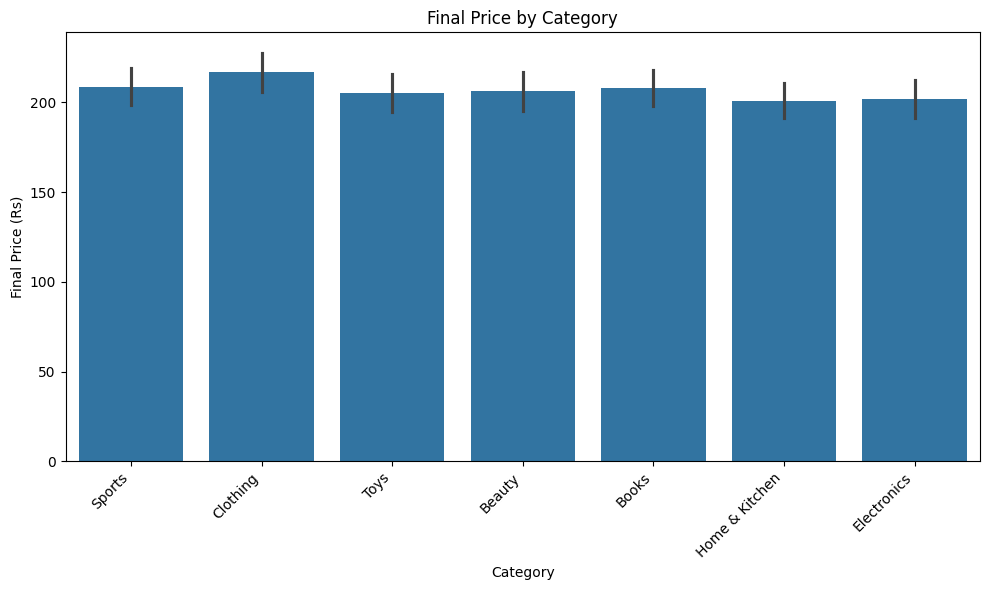

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function bar chart
def create_bar_chart(data, category_column, value_column, title, ylabel):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_column, y=value_column, data=data)
    plt.title(title)
    plt.xlabel(category_column.capitalize())
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create bar charts
create_bar_chart(pandas_df, 'category', 'priceRs', 'Price by Category', 'Price (Rs)')
create_bar_chart(pandas_df, 'category', 'discountPercent', 'Discount Percentage by Category', 'Discount (%)')
create_bar_chart(pandas_df, 'category', 'finalPriceRs', 'Final Price by Category', 'Final Price (Rs)')

Jumlah produk berdasarkan kategori (PIE CHART) <br>
data = category, priceRs, discountPercent, finalPriceRs

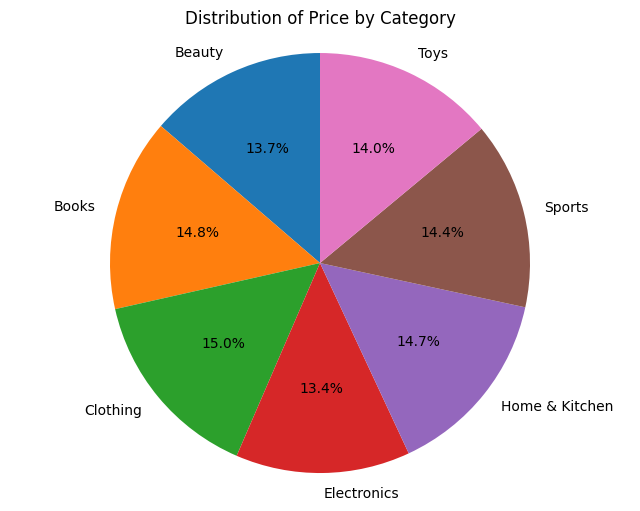

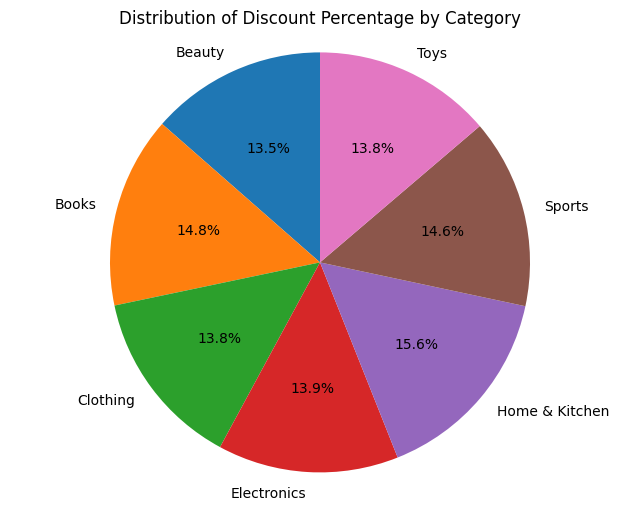

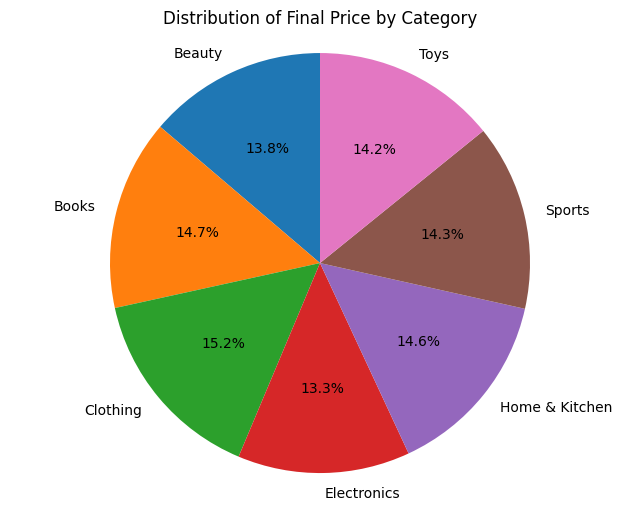

In [68]:
import matplotlib.pyplot as plt

# Function pie chart
def create_pie_chart(data, category_column, value_column, title):
    category_values = data.groupby(category_column)[value_column].sum()

    plt.figure(figsize=(8, 6))
    plt.pie(category_values, labels=category_values.index, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Create pie charts
create_pie_chart(pandas_df, 'category', 'priceRs', 'Distribution of Price by Category')
create_pie_chart(pandas_df, 'category', 'discountPercent', 'Distribution of Discount Percentage by Category')
create_pie_chart(pandas_df, 'category', 'finalPriceRs', 'Distribution of Final Price by Category')

Jumlah produk berdasarkan kategori (boxplot) <br>
data = category, priceRs, discountPercent, finalPriceRs

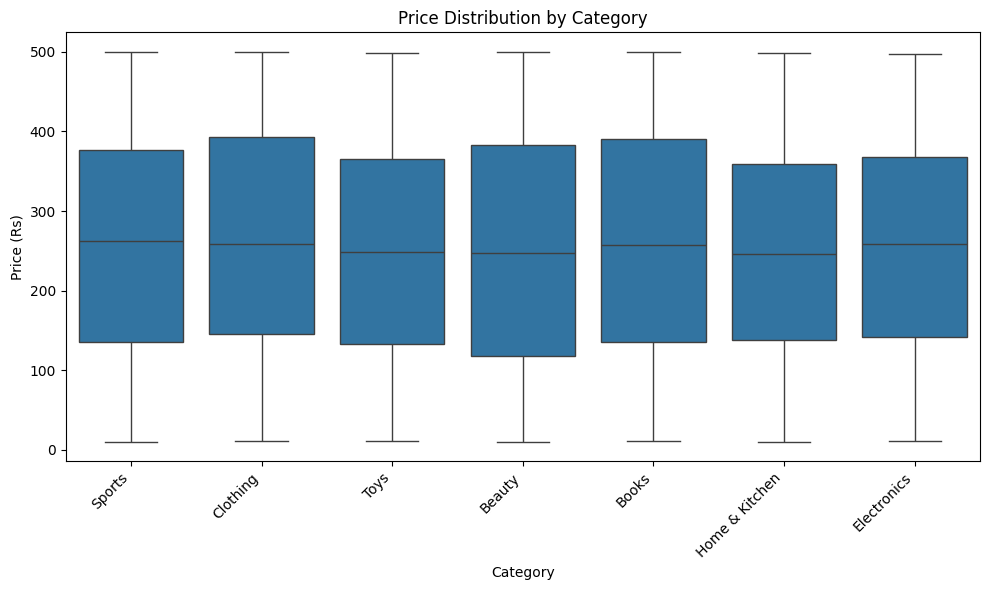

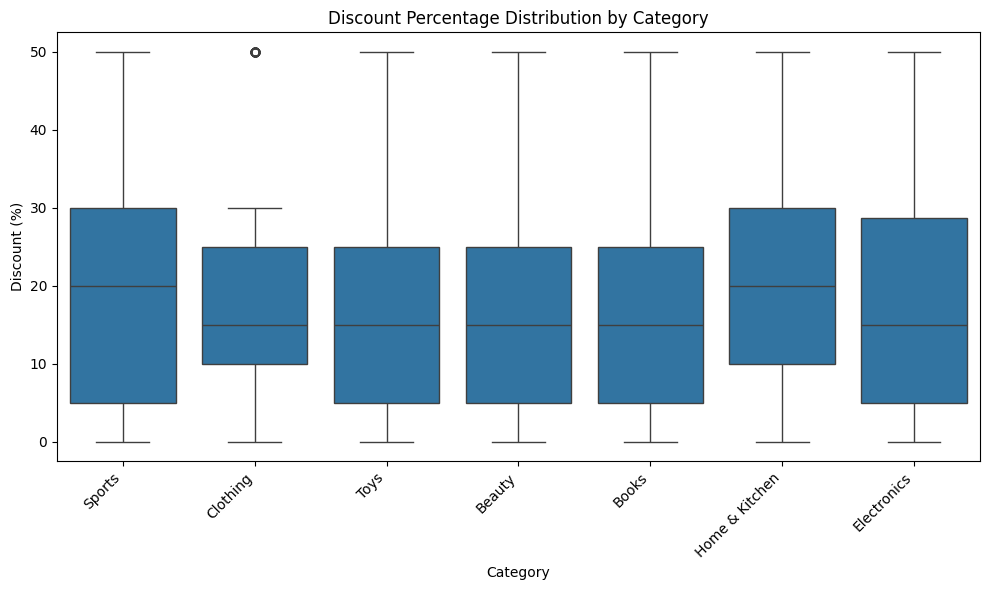

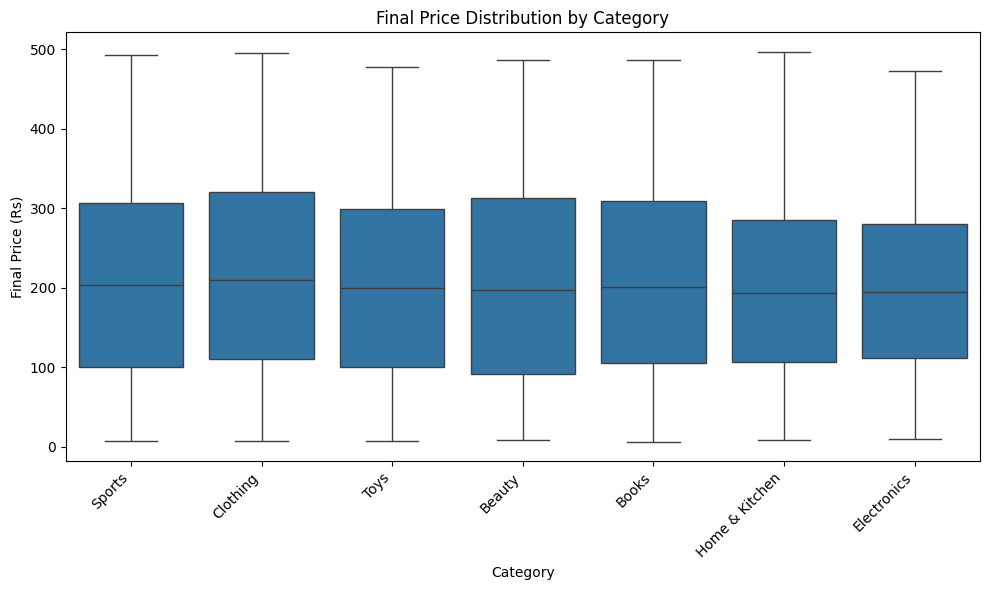

In [69]:
# Create box plot
def create_box_plot(data, category_column, value_column, title, ylabel):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=category_column, y=value_column, data=data)
    plt.title(title)
    plt.xlabel(category_column.capitalize())
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

create_box_plot(pandas_df, 'category', 'priceRs', 'Price Distribution by Category', 'Price (Rs)')
create_box_plot(pandas_df, 'category', 'discountPercent', 'Discount Percentage Distribution by Category', 'Discount (%)')
create_box_plot(pandas_df, 'category', 'finalPriceRs', 'Final Price Distribution by Category', 'Final Price (Rs)')

Jumlah produk berdasarkan kategori (histogram) <br>
data = category, priceRs, discountPercent, finalPriceRs

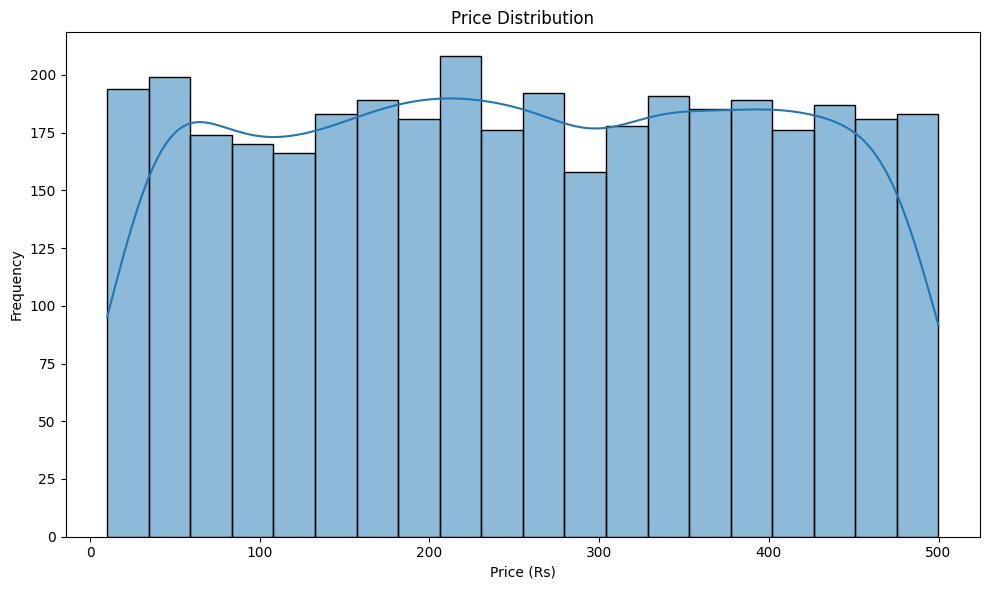

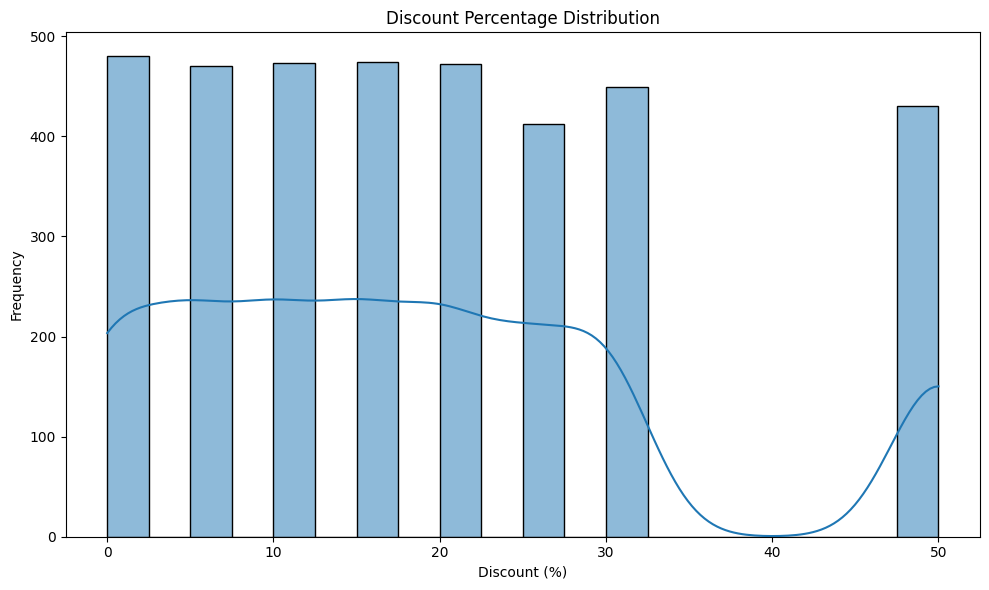

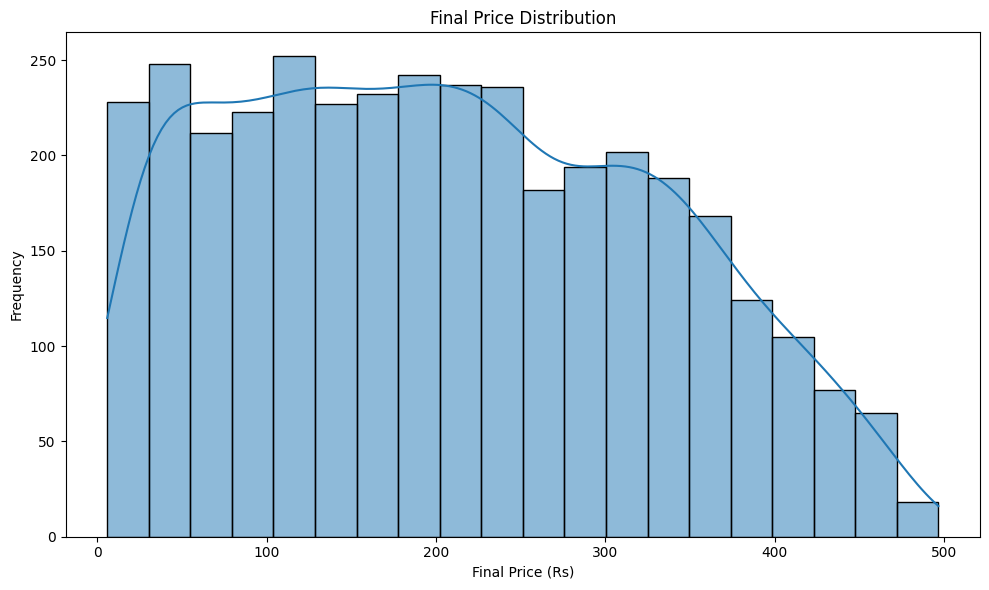

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create histogram
def create_histogram(data, column, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True, bins=20)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Create histograms
create_histogram(pandas_df, 'priceRs', 'Price Distribution', 'Price (Rs)', 'Frequency')
create_histogram(pandas_df, 'discountPercent', 'Discount Percentage Distribution', 'Discount (%)', 'Frequency')
create_histogram(pandas_df, 'finalPriceRs', 'Final Price Distribution', 'Final Price (Rs)', 'Frequency')


# 2a


Random Forest

In [71]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Data preprocessing
string_indexer = StringIndexer(inputCols=['category', 'paymentMethod'], outputCols=['categoryIndex', 'paymentMethodIndex'])
indexed_df = string_indexer.fit(spark_df).transform(spark_df)

assembler = VectorAssembler(inputCols=['categoryIndex', 'paymentMethodIndex', 'priceRs', 'discountPercent'], outputCol='features')
assembled_df = assembler.transform(indexed_df)

# Select relevant columns
model_df = assembled_df.select('features', 'finalPriceRs')

# buat data training dan testing
train_df, test_df = model_df.randomSplit([0.8, 0.2], seed=42)

# Train a RandomForestRegressor
rf_regressor = RandomForestRegressor(labelCol='finalPriceRs', featuresCol='features', numTrees=100) # Changed to rf_regressor
rf_model = rf_regressor.fit(train_df)

# predictions
predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol='finalPriceRs', predictionCol='prediction', metricName='rmse') # Changed to rmse
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')
predictions.select('features', 'finalPriceRs', 'prediction').show(10)

Root Mean Squared Error (RMSE): 22.614678067241947
+--------------------+------------+------------------+
|            features|finalPriceRs|        prediction|
+--------------------+------------+------------------+
|     (4,[2],[136.1])|       136.1|148.65235504845057|
|    (4,[2],[259.15])|      259.15| 273.7727352654195|
|    (4,[2],[301.37])|      301.37| 298.0920419854179|
| [0.0,0.0,16.18,5.0]|       15.37| 69.87980903620667|
|[0.0,0.0,53.69,25.0]|       40.27|60.158236731133705|
|[0.0,0.0,67.85,15.0]|       57.67| 82.72610557762658|
|[0.0,0.0,79.25,25.0]|       59.44| 71.88850625571462|
|[0.0,0.0,113.71,5.0]|      108.02| 97.41288154377638|
|[0.0,0.0,154.33,2...|      115.75|122.80638458972338|
|[0.0,0.0,156.47,1...|       133.0|141.67647420524628|
+--------------------+------------+------------------+
only showing top 10 rows



Gradient Boost Tree

In [72]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Data preprocessing for the model
string_indexer = StringIndexer(inputCols=['category', 'paymentMethod'], outputCols=['categoryIndex', 'paymentMethodIndex'])
indexed_df = string_indexer.fit(spark_df).transform(spark_df)

assembler = VectorAssembler(inputCols=['categoryIndex', 'paymentMethodIndex', 'priceRs', 'discountPercent'], outputCol='features')
assembled_df = assembler.transform(indexed_df)

# Select relevant columns
model_df = assembled_df.select('features', 'finalPriceRs')

# buat data training and testing
train_df, test_df = model_df.randomSplit([0.8, 0.2], seed=42)

# Train a GradientBoostedTreeRegressor model (GBTRegressor)
gbt_regressor = GBTRegressor(labelCol='finalPriceRs', featuresCol='features', maxIter=50)
gbt_model = gbt_regressor.fit(train_df)

# Make predictions on the testing set
predictions = gbt_model.transform(test_df)

# Evaluate the model using RegressionEvaluator
evaluator = RegressionEvaluator(labelCol='finalPriceRs', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')
predictions.select('features', 'finalPriceRs', 'prediction').show(10)


Root Mean Squared Error (RMSE): 5.352381180419983
+--------------------+------------+------------------+
|            features|finalPriceRs|        prediction|
+--------------------+------------+------------------+
|     (4,[2],[136.1])|       136.1| 140.8053802950578|
|    (4,[2],[259.15])|      259.15|257.69893274938164|
|    (4,[2],[301.37])|      301.37| 314.3792684468161|
| [0.0,0.0,16.18,5.0]|       15.37|17.353972972377417|
|[0.0,0.0,53.69,25.0]|       40.27| 42.90948118340265|
|[0.0,0.0,67.85,15.0]|       57.67| 65.16907300547791|
|[0.0,0.0,79.25,25.0]|       59.44| 55.75948695421169|
|[0.0,0.0,113.71,5.0]|      108.02|102.91000679287457|
|[0.0,0.0,154.33,2...|      115.75|118.69632605759243|
|[0.0,0.0,156.47,1...|       133.0|131.99504181818986|
+--------------------+------------+------------------+
only showing top 10 rows



Generalized Linear Regression dan Isotonic Regression RMSE

In [ ]:
from pyspark.ml.regression import IsotonicRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Model 1: Generalized Linear Regression (GLR)
glr = GeneralizedLinearRegression(labelCol='finalPriceRs', featuresCol='features', family='gaussian', link='identity', maxIter=100, regParam=0.1)
glr_model = glr.fit(train_df)

# Make predictions using Generalized Linear Regression
glr_predictions = glr_model.transform(test_df)

# Evaluate Generalized Linear Regression Model
glr_rmse = evaluator.evaluate(glr_predictions)
print(f'Generalized Linear Regression RMSE: {glr_rmse}')

# Show some predictions for Generalized Linear Regression
glr_predictions.select('features', 'finalPriceRs', 'prediction').show(10)

# Model 2: Isotonic Regression
isotonic_regressor = IsotonicRegression(labelCol='finalPriceRs', featuresCol='features')
isotonic_model = isotonic_regressor.fit(train_df)

# Make predictions using Isotonic Regression
isotonic_predictions = isotonic_model.transform(test_df)

# Evaluate Isotonic Regression Model
isotonic_rmse = evaluator.evaluate(isotonic_predictions)
print(f'Isotonic Regression RMSE: {isotonic_rmse}')

# Show some predictions for Isotonic Regression
isotonic_predictions.select('features', 'finalPriceRs', 'prediction').show(10)

Generalized Linear Regression RMSE: 21.312077499611163
+--------------------+------------+------------------+
|            features|finalPriceRs|        prediction|
+--------------------+------------+------------------+
|     (4,[2],[136.1])|       136.1|159.08474305107404|
|    (4,[2],[259.15])|      259.15| 258.7301295204159|
|    (4,[2],[301.37])|      301.37| 292.9197127527249|
| [0.0,0.0,16.18,5.0]|       15.37|49.058915622635524|
|[0.0,0.0,53.69,25.0]|       40.27| 27.77395152512623|
|[0.0,0.0,67.85,15.0]|       57.67|  65.0708658830104|
|[0.0,0.0,79.25,25.0]|       59.44|48.472334931516954|
|[0.0,0.0,113.71,5.0]|      108.02| 128.0383105219034|
|[0.0,0.0,154.33,2...|      115.75|109.27181169801992|
|[0.0,0.0,156.47,1...|       133.0| 136.8349792427266|
+--------------------+------------+------------------+
only showing top 10 rows

Isotonic Regression RMSE: 120.94558245606468
+--------------------+------------+------------------+
|            features|finalPriceRs|        predic

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluator untuk regresi
evaluator_rmse = RegressionEvaluator(labelCol="finalPriceRs", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="finalPriceRs", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="finalPriceRs", predictionCol="prediction", metricName="mae")

def evaluate_model(predictions, model_name):
    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    print(f"{model_name} Metrics:")
    print(f" - RMSE: {rmse}")
    print(f" - R²: {r2}")
    print(f" - MAE: {mae}")
    print()

# Evaluasi Gradient Boosted Tree
evaluate_model(predictions, "Gradient Boosted Tree")

# Evaluasi Random Forest
rf_predictions = rf_model.transform(test_df)  # Ganti dengan prediksi dari model Random Forest
evaluate_model(rf_predictions, "Random Forest")

# Evaluasi Generalized Linear Regression
evaluate_model(glr_predictions, "Generalized Linear Regression")

# Evaluasi Isotonic Regression
evaluate_model(isotonic_predictions, "Isotonic Regression")

Gradient Boosted Tree Metrics:
 - RMSE: 5.352381180419983
 - R²: 0.9980418917091434
 - MAE: 4.144485114028693

Random Forest Metrics:
 - RMSE: 22.614678067241947
 - R²: 0.965043861156851
 - MAE: 17.91167166129657

Generalized Linear Regression Metrics:
 - RMSE: 21.312077499611163
 - R²: 0.9689548180286949
 - MAE: 14.868176291962198

Isotonic Regression Metrics:
 - RMSE: 120.94558245606468
 - R²: 0.00017807301825956134
 - MAE: 101.98885188630653



#2b

In [63]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluator untuk regresi
evaluator = RegressionEvaluator(labelCol="finalPriceRs", predictionCol="prediction", metricName="rmse")

# Model 1: Hyperparameter Tuning untuk Gradient Boosted Tree
gbt_param_grid = (
    ParamGridBuilder()
    .addGrid(gbt_regressor.maxDepth, [3, 5, 7])  # Uji kedalaman pohon
    .addGrid(gbt_regressor.maxIter, [50, 100])  # Uji jumlah iterasi
    .build()
)

gbt_cv = CrossValidator(
    estimator=gbt_regressor,
    estimatorParamMaps=gbt_param_grid,
    evaluator=evaluator,
    numFolds=3  # Gunakan 3-fold cross-validation
)

# Jalankan cross-validation untuk Gradient Boosted Tree
gbt_cv_model = gbt_cv.fit(train_df)
gbt_best_model = gbt_cv_model.bestModel
gbt_predictions = gbt_best_model.transform(test_df)

# Evaluasi model terbaik untuk Gradient Boosted Tree
gbt_rmse = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Tree (Tuned) RMSE: {gbt_rmse}")

# Model 2: Hyperparameter Tuning untuk Random Forest
rf_param_grid = (
    ParamGridBuilder()
    .addGrid(rf_regressor.numTrees, [20, 50, 100])  # Uji jumlah pohon
    .addGrid(rf_regressor.maxDepth, [5, 10])  # Uji kedalaman maksimum
    .build()
)

rf_cv = CrossValidator(
    estimator=rf_regressor,
    estimatorParamMaps=rf_param_grid,
    evaluator=evaluator,
    numFolds=3  # Gunakan 3-fold cross-validation
)

# Jalankan cross-validation untuk Random Forest
rf_cv_model = rf_cv.fit(train_df)
rf_best_model = rf_cv_model.bestModel
rf_predictions = rf_best_model.transform(test_df)

# Evaluasi model terbaik untuk Random Forest
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest (Tuned) RMSE: {rf_rmse}")


Gradient Boosted Tree (Tuned) RMSE: 4.639359376739866
Random Forest (Tuned) RMSE: 6.917639668780736
